# YouTube Data API v3

### Python Libraries

In [1]:
import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

import collections

### Imported Scripts

In [29]:
    # api_key is stored in config.py
import config

    # Functions for making youtube_requests
import youtube_requests

    # Functions for data processing
import data_processing

    # Functions for creating a network graph    
import network_graphs

import importlib
importlib.reload(network_graphs)

<module 'network_graphs' from '/Users/DanOvadia/Projects/YoutubeChannels/network_graphs.py'>

In [3]:
%load_ext autoreload

In [4]:
%autoreload 1

In [5]:
%aimport network_graphs
%aimport youtube_requests

# YouTube Channel Details by Search

Returns a details list of channels for a specific search query and number of requested results.

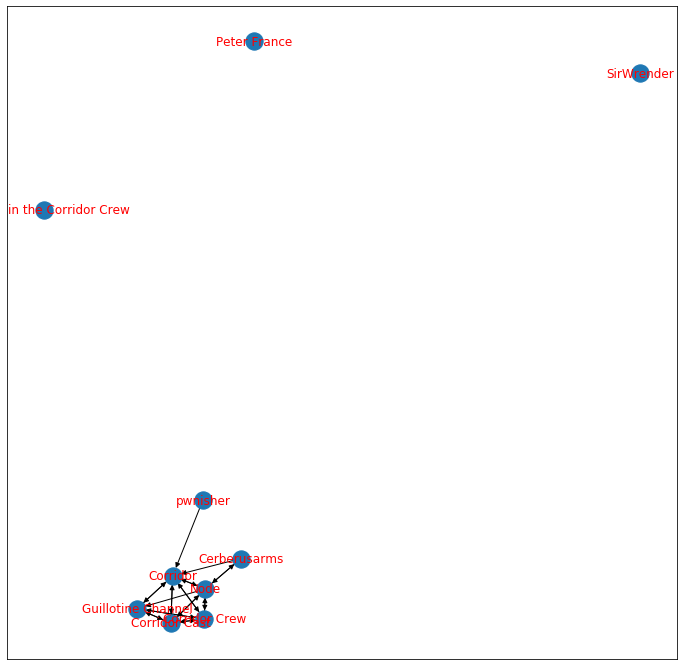

In [244]:
# Get a list of dictionaries, where each dictionary represents details for a specific channel
CHANNELS_DETAILS_ITEMS_LIST = youtube_requests.youtube_channel_details_by_search('corridor crew',10)

# Graph the network of channels
G = network_graphs.create_nx_graph(CHANNELS_DETAILS_ITEMS_LIST, directed=True)

# Extract a columnar list of channel details
CHANNELS_DETAILS_LIST = data_processing.extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Create a dataframe
#DF = data_processing.create_df_from_details_list(CHANNELS_DETAILS_LIST)

# Graph G
network_graphs.graph_nx_graph(G)

# Youtube Channel Details by Network

In [117]:
AGADMATOR = CHANNELS_DETAILS_ITEMS_LIST[1:3]

In [109]:
CHESSCOM = [CHANNELS_DETAILS_ITEMS_LIST[3]]

In [ ]:
TANA_MONGEAU = 

In [91]:
HERMITCRAFT = CHANNELS_DETAILS_ITEMS_LIST

In [83]:
JAMES_HOFFMAN = [CHANNELS_DETAILS_ITEMS_LIST[2]]

In [66]:
SCOTT_MANLEY = [CHANNELS_DETAILS_ITEMS_LIST[0]]

In [ ]:
PLFL_RESP_LIST

In [61]:
PLFL_RESP_LIST = [CHANNELS_DETAILS_ITEMS_LIST[1]]

In [24]:
CORRIDOR_RESP = CHANNELS_DETAILS_ITEMS_LIST[3:5]

In [210]:
indices = [0,3,4,8,9]
[channel['snippet']['title'] for channel in CHANNELS_DETAILS_ITEMS_LIST]
CORRIDOR_FULL = [CHANNELS_DETAILS_ITEMS_LIST[i] for i in indices]


-------

25 total neighbors; 0 out of 5 channels do not feature channels
97 total neighbors; 2 out of 20 channels do not feature channels


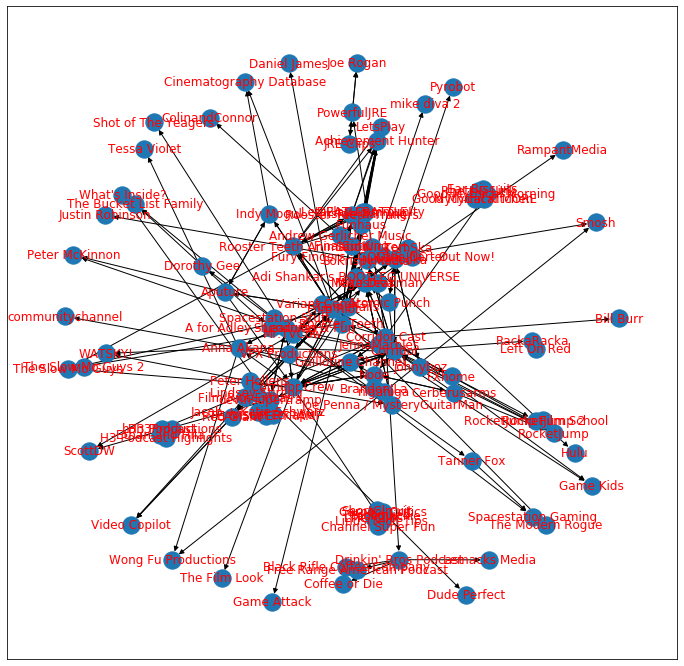

In [247]:
# Get a list of dictionaries, where each dictionary represents details for a specific channel
CHANNELS_DETAILS_ITEMS_LIST = youtube_requests.youtube_channel_details_by_network(CORRIDOR_FULL, 2)

# Graph the network of channels
G = network_graphs.create_nx_graph(CHANNELS_DETAILS_ITEMS_LIST, True)

# Extract a columnar list of channel details
CHANNELS_DETAILS_LIST = data_processing.extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Create a dataframe
DF = data_processing.create_df_from_details_list(CHANNELS_DETAILS_LIST)

# Graph G
network_graphs.graph_nx_graph(G)

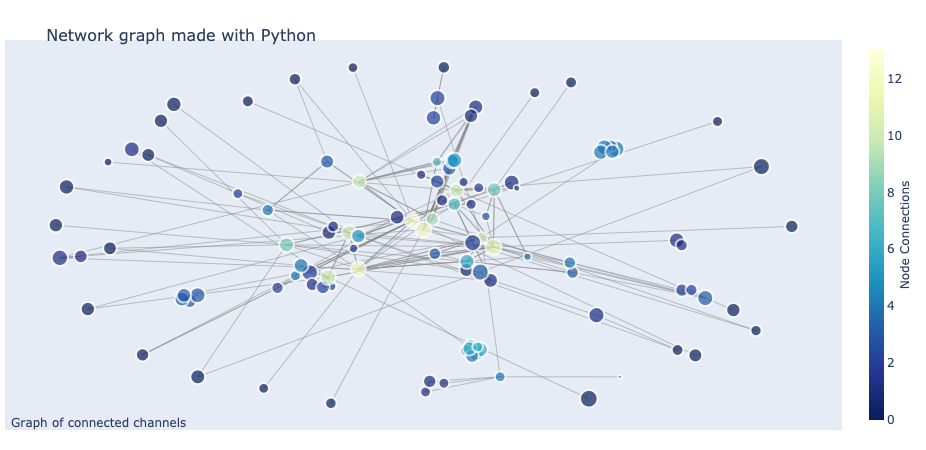

In [248]:
network_graphs.plotly_network_graph(G)

## Page Rank

In [253]:
page_rank_series = pd.Series(data = network_graphs.simple_page_rank(G), index = list(G.nodes().keys()))
DF['page_rank'] = DF['id'].map(lambda x:page_rank_series[x])

betweenness_dict = nx.betweenness_centrality(G)
DF['betweenness_centrality'] = DF['id'].map(lambda x:betweenness_dict[x])

in_degree_centrality_dict = nx.in_degree_centrality(G)
DF['in_degree_centrality'] = DF['id'].map(lambda x:in_degree_centrality_dict[x])

in_degree_dict = {node:G.in_degree()[node] for node in G.nodes()}
DF['in_degree'] = DF['id'].map(lambda x:in_degree_dict[x])



In [257]:
degree_dict = {node:G.degree()[node] for node in G.nodes()}
DF['degree'] = DF['id'].map(lambda x:degree_dict[x])

In [259]:
DF[['title','subscriberCount','viewCount','page_rank','featuredChannelsCount','degree','in_degree','betweenness_centrality','in_degree_centrality']].sort_values(
    'in_degree_centrality', ascending=False).head(8)

,title,subscriberCount,viewCount,page_rank,featuredChannelsCount,degree,in_degree,betweenness_centrality,in_degree_centrality
1,Corridor,8060000,1463201240,3.350372e-02,11,25,14,0.183506,0.127273
54,LetsPlay,3850000,2431472112,6.639924e-17,1,10,9,0.000042,0.081818
15,Rooster Teeth,9470000,6077125022,5.619542e-04,12,20,8,0.040979,0.072727
2,Corridor Crew,4090000,706379962,4.729505e-02,12,20,8,0.146542,0.072727
22,Nukazooka,2250000,669120470,1.790866e-02,8,16,8,0.042045,0.072727
10,Film Riot,1670000,191530960,1.663137e-02,13,21,8,0.076642,0.072727
14,Linus Tech Tips,11500000,3899555479,9.158502e-02,6,13,7,0.020559,0.063636
89,Funhaus,1680000,1411592121,1.896551e-04,3,10,7,0.000028,0.063636


Betweenness centrality measures the extent to which a vertex lies on paths between other vertices. Vertices with high betweenness may have considerable influence within a network by virtue of their control over information passing between others. They are also the ones whose removal from the network will most disrupt communications between other vertices because they lie on the largest number of paths taken by messages.

Mathematically, let $n_{s,t}^{i}$ be the number of geodesic paths from $s$ to $t$ that pass through $i$ and let $n_{s,t}$ be the total number of geodesic paths from $s$ to $t$. Recall that a geodesic path is not necessarily unique and the geodesic paths between a pair of vertices need not be node-independent, meaning they may pass through some of the same vertices. Then the betweenness centrality of vertex $i$ is:
Mathematically, let $n_{s,t}^{i}$ be the number of geodesic paths from $s$ to $t$ that pass through $i$ and let $n_{s,t}$ be the total number of geodesic paths from $s$ to $t$. Recall that a geodesic path is not necessarily unique and the geodesic paths between a pair of vertices need not be node-independent, meaning they may pass through some of the same vertices. Then the betweenness centrality of vertex $i$ is:
$\displaystyle{b_i = \sum_{s, t} w_{s,t}^{i} = \sum_{s, t} \frac{n_{s,t}^{i}}{n_{s,t}}}$

where by convention the ratio $w_{s,t}^{i} = 0$ if $n_{s,t} = 0$. Notice that each pair of vertex $s, t$ contribute to the sum for $i$ with a weight $w_{s,t}^{i}$ between 0 and 1 expressing the betweenness of $i$ with respect to the pair $s, t$. Observe that:
the given definition counts separately the geodesic paths in either direction between each vertex pair. Since these paths are the same on an undirected graph this effectively counts each path twice;
the definition includes paths starting or ending with $i$ ($s$ can be equal to $i$ or $t$ can be equal to $i$), as well as paths from a vertex to itself ($s$ can be equal to $t$). It seems reasonable to define a vertex to be on a path between itself and someone else, or between some vertex and itself, since normally a vertex has control over information flowing from or to itself.
It makes little difference in practice to consider the alternative definitions, since one is usually concerned only with the relative magnitudes of the centralities and not with their absolute values. The sum can be normalized by dividing by the total number of ordered pairs of nodes, which is $n^2$, so that betweenness lies strictly between 0 and 1.

Consider the following graph:

In [236]:
betweenness_dict = nx.betweenness_centrality(G)
in_degree_dict = nx.in_degree_centrality(G)
DF['betweenness_centrality'] = DF['id'].map(lambda x:betweenness_dict[x])
DF['in_degree_centrality'] = DF['id'].map(lambda x:in_degree_dict[x])

In [242]:
DF[['title','id','subscriberCount','viewCount','featuredChannelsCount', 'page_rank','betweenness_centrality','in_degree_centrality']].sort_values('betweenness_centrality', ascending=False).head(8)

,title,id,subscriberCount,viewCount,featuredChannelsCount,page_rank,betweenness_centrality,in_degree_centrality
1,Corridor,UCsn6cjffsvyOZCZxvGoJxGg,8060000,1463201240,11,0.033504,0.183506,0.127273
2,Corridor Crew,UCSpFnDQr88xCZ80N-X7t0nQ,4090000,706379962,12,0.047295,0.146542,0.072727
0,Corridor Cast,UCNSeDrWRGxx5p2l3tj7RWQw,110000,4990166,10,0.023768,0.100167,0.036364
9,Film Riot,UC6P24bhhCmMPOcujA9PKPTA,1670000,191530960,13,0.016631,0.076642,0.072727
10,devinsupertramp,UCwgURKfUA7e0Z7_qE3TvBFQ,5920000,1436104201,10,0.010800,0.069323,0.063636
20,Shonduras,UCoK5NOxkZBLfI_5eqf8Es4Q,2440000,1627843555,10,0.011660,0.059808,0.045455
22,SoKrispyMedia,UCKo61AAaRD00ibCWJZ321MQ,1130000,315544020,10,0.011749,0.055512,0.063636
23,Mike Diva,UC6Je0KLSDuKLfKs1lEBzKrQ,650000,142736100,7,0.009866,0.045655,0.063636


In [243]:
DF[['title','id','subscriberCount','viewCount','featuredChannelsCount', 'page_rank','betweenness_centrality','in_degree_centrality']].sort_values('in_degree_centrality', ascending=False).head(8)

,title,id,subscriberCount,viewCount,featuredChannelsCount,page_rank,betweenness_centrality,in_degree_centrality
1,Corridor,UCsn6cjffsvyOZCZxvGoJxGg,8060000,1463201240,11,3.350372e-02,0.183506,0.127273
52,LetsPlay,UCkxctb0jr8vwa4Do6c6su0Q,3850000,2431472112,1,6.639924e-17,0.000042,0.081818
2,Corridor Crew,UCSpFnDQr88xCZ80N-X7t0nQ,4090000,706379962,12,4.729505e-02,0.146542,0.072727
16,Nukazooka,UCQqi--mpTFtGNim0WCtPH-A,2250000,669120470,8,1.790866e-02,0.042045,0.072727
14,Rooster Teeth,UCzH3iADRIq1IJlIXjfNgTpA,9470000,6077125022,12,5.619542e-04,0.040979,0.072727
9,Film Riot,UC6P24bhhCmMPOcujA9PKPTA,1670000,191530960,13,1.663137e-02,0.076642,0.072727
23,Mike Diva,UC6Je0KLSDuKLfKs1lEBzKrQ,650000,142736100,7,9.865906e-03,0.045655,0.063636
22,SoKrispyMedia,UCKo61AAaRD00ibCWJZ321MQ,1130000,315544020,10,1.174942e-02,0.055512,0.063636


In [272]:
scc_list = [scc for scc in nx.strongly_connected_components(G)]

In [ ]:
scc_list[42]

In [278]:
H = G.subgraph(list(scc_list[42]))

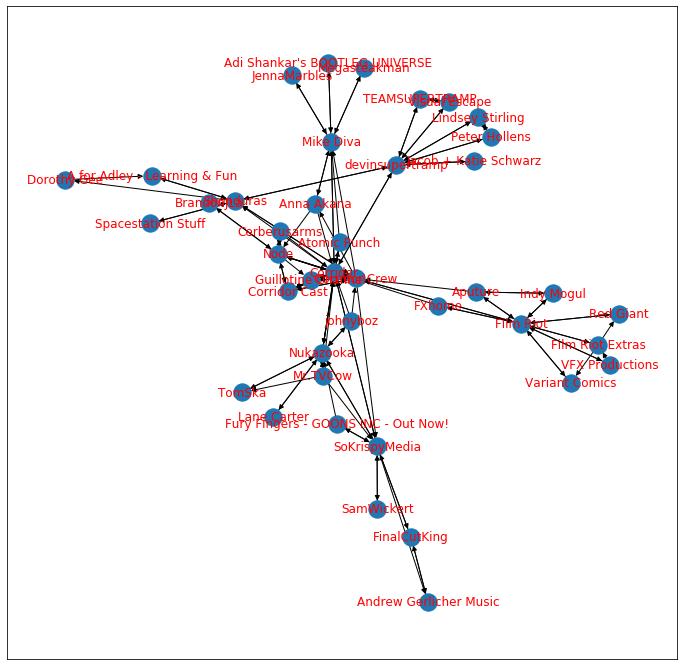

In [281]:
network_graphs.graph_nx_graph(H)

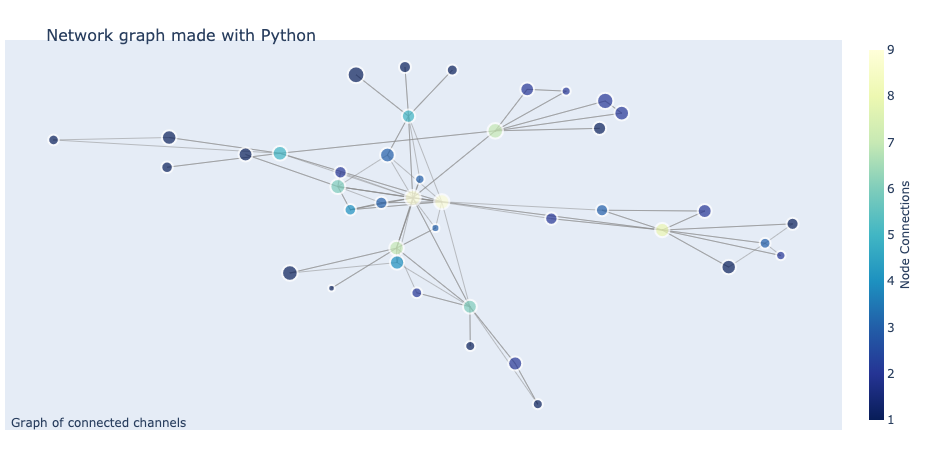

In [282]:
network_graphs.plotly_network_graph(H)